# Data Exploration of the Pima Indians Diabetes Dataset

The goal of this data exploration is to better understand the dataset and prepare it for further analysis and model building. The dataset consists of diagnostic information from **female patients over the age of 21**, and the objective is to predict whether or not a patient has diabetes based on these measurements.

### Target Variable:
- **Outcome**: A binary variable indicating whether the individual has diabetes:
  - **1**: The individual has diabetes.
  - **0**: The individual does not have diabetes.

### Feature Variables:
- **Pregnancies**: The number of pregnancies the patient has had.
- **Age**: The age of the patient in years.
- **Glucose**: Plasma glucose concentration during a 2-hour oral glucose tolerance test.
- **Blood Pressure (BP)**: Diastolic blood pressure (in $mm Hg$).
- **Skin Thickness**: Triceps skin fold thickness (in $mm$).
- **Insulin**: 2-hour serum insulin concentration (in $ \mu U/ml$).
- **BMI**: Body Mass Index ($kg/m^2$).
- **Diabetes Pedigree Function (DPF)**: A function based on family history of diabetes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans

import utils.plotting_eda as plot_eda
import utils.data_preprocessing as data_proc
import pipelines.custom_pipeline_components as pipeline_comp

## 1. Check the Summary of the Data

- **View the first few rows** to get an overview of the data format and ensure it has been loaded correctly.
- **Check for missing values** to identify any variables requiring cleaning or imputation.
- **Review data types** to confirm that each column matches its expected type (e.g., numeric for measurements, categorical for the target variable).
- **Summary statistics** for numerical features (mean, standard deviation, min, max) to help identify outliers or unusual data points.
- **Check for duplicates** to avoid double-counting patients, which could skew the analysis and model performance.



In [3]:
# Load and prepare the dataset
data = pd.read_csv("../data/preprocessed_diabetes_train.csv")

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,7,184,84,33,0,35.5,0.355,41,1
1,6,85,78,0,0,31.2,0.382,42,0
2,2,106,64,35,119,30.5,1.400,34,0
3,2,100,54,28,105,37.8,0.498,24,0
4,5,104,74,0,0,28.8,0.153,48,0


In [5]:
# Display summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               537 non-null    int64  
 1   Glucose                   537 non-null    int64  
 2   BloodPressure             537 non-null    int64  
 3   SkinThickness             537 non-null    int64  
 4   Insulin                   537 non-null    int64  
 5   BMI                       537 non-null    float64
 6   DiabetesPedigreeFunction  537 non-null    float64
 7   Age                       537 non-null    int64  
 8   Outcome                   537 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 37.9 KB


In [6]:
# Display summary statistics of the dataset
data.describe().round(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,537.0,537.0,537.0,537.0,537.0,537.0,537.0,537.0,537.0
mean,3.9,120.9,69.1,20.4,78.5,32.1,0.5,33.6,0.3
std,3.4,31.3,19.0,15.5,108.7,7.8,0.3,11.8,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.1,21.0,0.0
25%,1.0,99.0,62.0,0.0,0.0,27.7,0.2,24.0,0.0
50%,3.0,117.0,72.0,23.0,38.0,32.4,0.4,30.0,0.0
75%,6.0,141.0,80.0,32.0,130.0,36.4,0.6,41.0,1.0
max,17.0,198.0,122.0,60.0,744.0,67.1,2.3,81.0,1.0


In [7]:
# Check if there are any identical rows
data.duplicated().any()

False

#### Summary:
- No NaN values found in the dataset.
- Data types were confirmed to be numeric.
- Summary statistics revealed:
    - High insulin values and zero values for Glucose, BloodPressure, SkinThickness, Insulin, and BMI, which are likely missing data points set to zero.
- No duplicate rows detected, ensuring data integrity for analysis and model building.

## 2. Analysis of the Variables

- **Distribution of variables**: Visualizing each feature to understand its spread (histograms and box plots).
- **Zero values investigation**: Identifying why certain features have zero values, which could indicate missing data.
- **Correlation analysis**: Using a correlation matrix to identify relationships between features, which may help in selecting imputation methods.

In [8]:
# Rename specific columns
data.rename(columns={'BloodPressure': 'BP', 'SkinThickness': 'Skin', 'DiabetesPedigreeFunction': 'DPF'}, inplace=True)
target = "Outcome"
features = ['Pregnancies', 'Glucose', 'BP', 'Skin', 'Insulin', 'BMI', 'DPF', 'Age']

#### Class Distribution

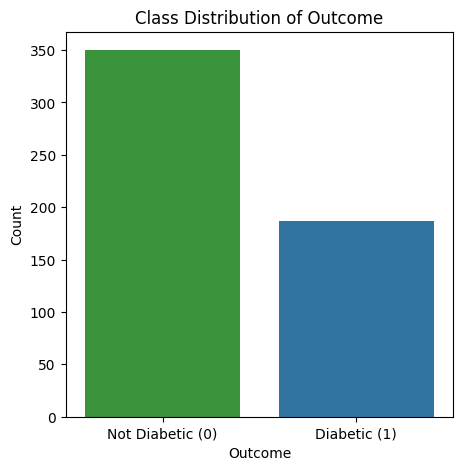

Class Distribution of Outcome:
Outcome
0    350
1    187
Name: count, dtype: int64

Class Percentages of Outcome:
Outcome
0    65.176909
1    34.823091
Name: count, dtype: float64


In [9]:
plot_eda.plot_class_distribution(data, "Outcome")

#### Check distribution of features

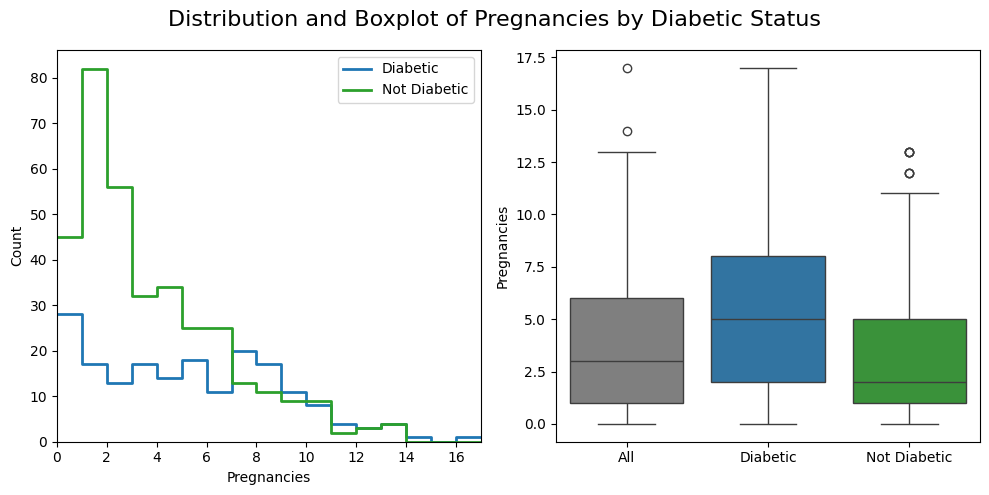

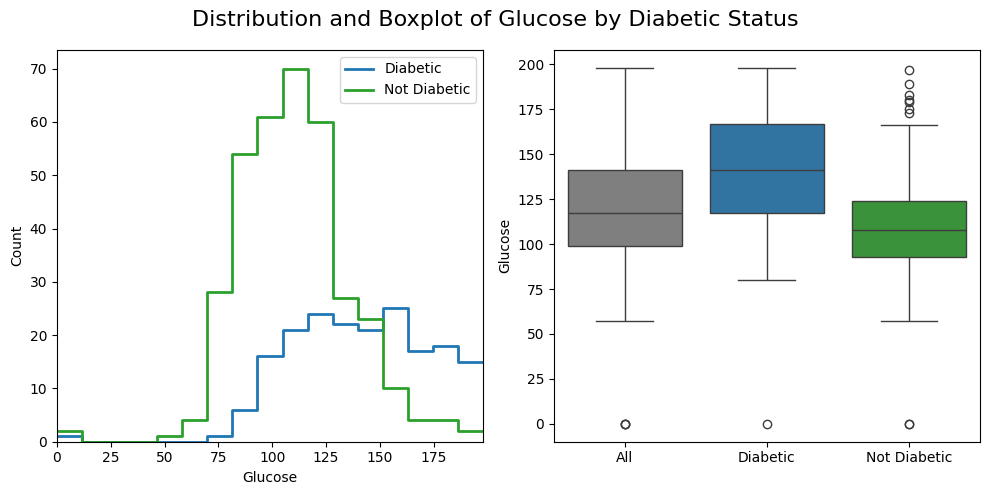

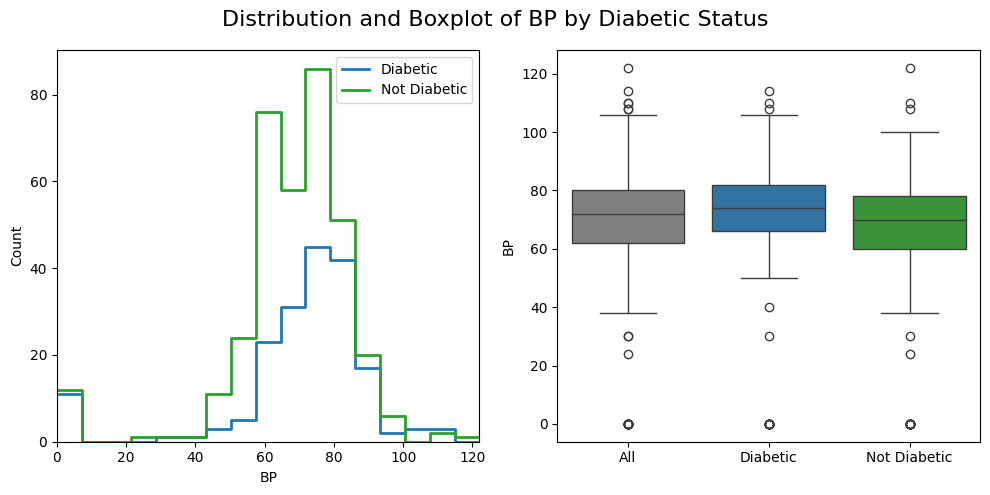

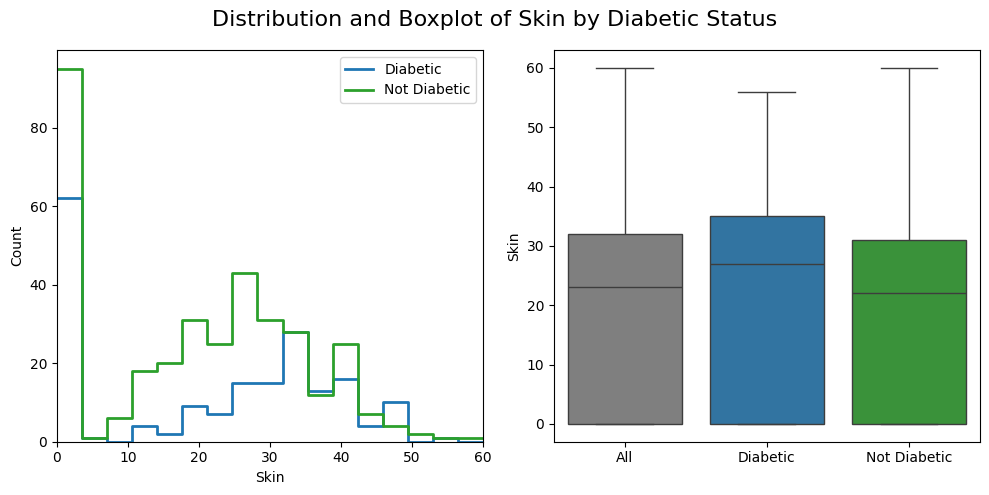

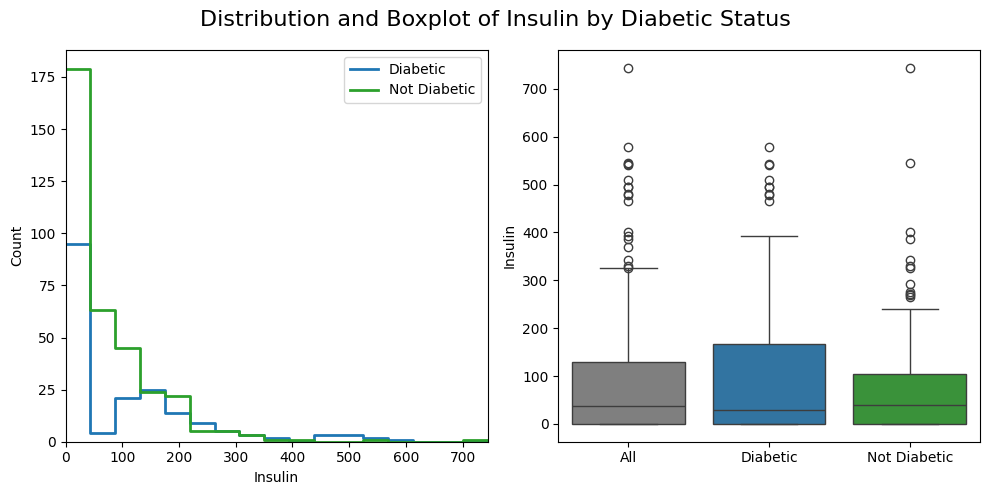

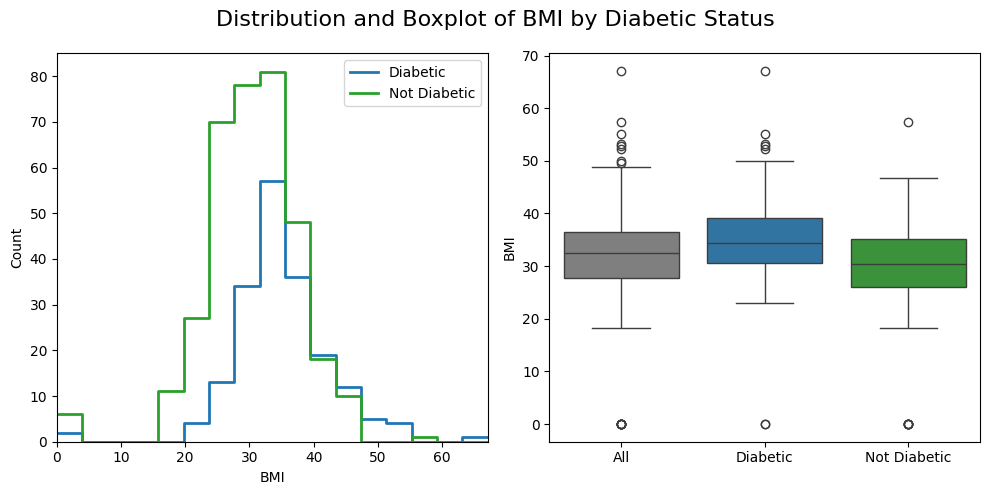

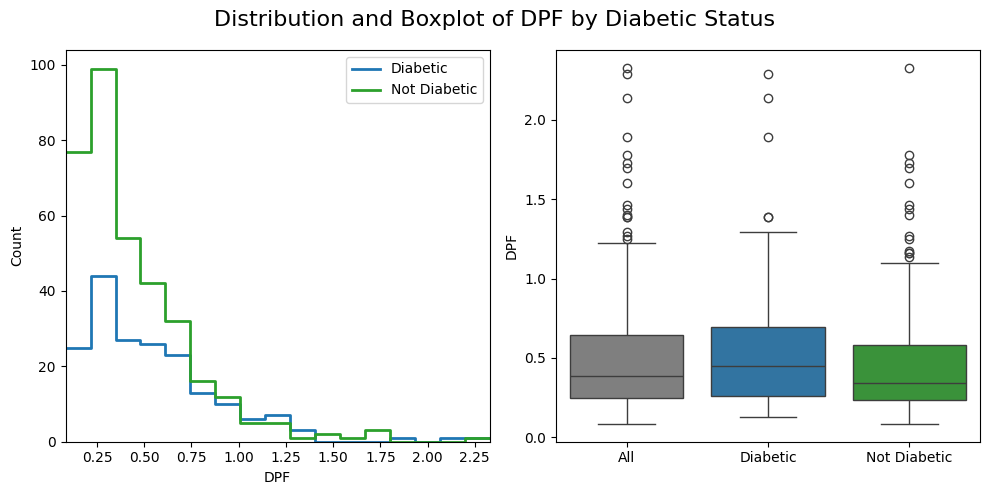

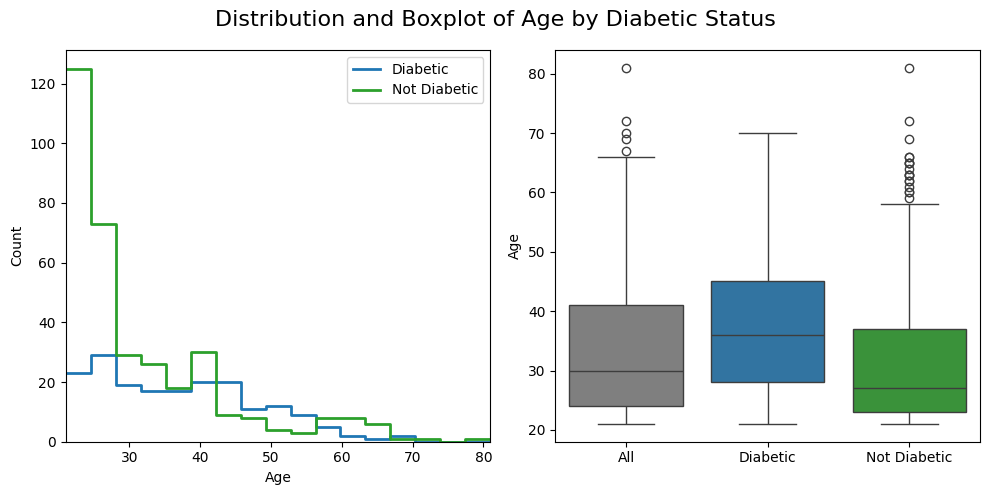

In [10]:
for feature in features:
    plot_eda.plot_distribution_and_boxplot(data, feature, target)

### Zero Values in Features:
For several features such as **Glucose**, **Blood Pressure**, **Skin Thickness**, **Insulin**, and **BMI**, missing values are represented by zeroes (0), indicating that no measurements were available for those specific records.

To handle these missing values effectively:
1. **Determine the frequency** of missing values for each feature, i.e., how often a feature has no available measurements.
2. **Examine the distribution** of missing data across examples (rows), specifically counting how many records have 0, 1, 2, or more missing values.


In [11]:
# List of features that may contain no measurements (represented by zeros)
features_no_measurements = ["Glucose", "BP", "Skin", "Insulin", "BMI"]

# Count the number of zeros (missing values) for each feature
zeros_per_feature = (data[features_no_measurements] == 0).sum(axis=0)
print("Features with corresponding number of missing (zero) values:")
print(zeros_per_feature, "\n")

# Count how many zeros (missing values) are in each row (example)
zeros_per_row = (data[features_no_measurements] == 0).sum(axis=1)

# Frequency of rows with various numbers of zeros
zeros_count = zeros_per_row.value_counts().sort_index()

print("Frequency of rows with various numbers of missing (zero) values:")
print(zeros_count)


Features with corresponding number of missing (zero) values:
Glucose      3
BP          23
Skin       157
Insulin    256
BMI          8
dtype: int64 

Frequency of rows with various numbers of missing (zero) values:
0    279
1     96
2    140
3     17
4      5
Name: count, dtype: int64


### Ideas on How to Deal with these Missing Values

- **Dataset Size**: With only **573 training and total of 768 examples**, removing rows with missing values may significantly reduce the dataset size, which is already small.
  
- **Imputation with Mean/Median**: Impute missing values using the **overall mean or median** of the feature, not by class, to avoid bias and overfitting.

- **KNN Imputation**: Use **K-Nearest Neighbors** to impute missing values based on features that don't have missing data.
 
- **Correlation Analysis**: Perform **correlation analysis** on subset of data with no missing values in any feature to identify which features are strongly correlated. Use these features for KNN imputation.



#### Correlation between features on data with no missing values


In [12]:
data_no_missing = data.loc[zeros_per_row == 0]
data_no_missing.describe().round(1)

,Pregnancies,Glucose,BP,Skin,Insulin,BMI,DPF,Age,Outcome
count,279.0,279.0,279.0,279.0,279.0,279.0,279.0,279.0,279.0
mean,3.3,123.1,70.5,29.0,150.6,33.1,0.5,31.6,0.3
std,3.2,30.9,12.6,10.3,109.0,7.0,0.3,10.6,0.5
min,0.0,68.0,24.0,7.0,16.0,18.2,0.1,21.0,0.0
25%,1.0,99.0,62.0,21.0,76.0,28.5,0.3,24.0,0.0
50%,2.0,119.0,70.0,29.0,126.0,33.3,0.5,28.0,0.0
75%,5.0,144.0,80.0,36.0,182.0,37.0,0.7,38.0,1.0
max,17.0,198.0,110.0,60.0,744.0,67.1,2.3,81.0,1.0


#### Correlation matrix
- The pairwise correlation between varaible x and y is determined using the Pearson or the Kendall coefficient.
- High correlation
    - **Pregnancies** and **Age**
    - **Glucose** and **Insulin**
    - **Blood Pressure (BP)** and **Body Mass Index (BMI)**
    - **Skin Thickness** and **BMI**
    - **Diabetes Pedigree Function (DPF)** and **Skin Thickness**

**Pearson**
Quantifies the linear relationship between x and y
$$
r_{xy} = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$$

- $n$ is the sample size
- $x_i, y_i$ represent the variable values for data point i
- $\bar{x}, \bar{y}$ are the sample means of $x$ and $y$ respectively.

**Kendall**
Quantifies the monotoenous relationship betweenn x and y
$$
\tau = \frac{2}{n(n-1)} \sum_{i<j} \text{sgn}(x_i - x_j) \text{sgn}(y_i - y_j)
$$

- $\text{sgn}(x_i - x_j)$ represents the sign function, which determines whether the pair $(x_i, y_i)$ is concordant or discordant with $(x_j, y_j)$.


In [13]:
# Calculate the correlation matrix excluding the target variable
corr_matrix = data_no_missing.drop('Outcome', axis=1).corr()
# For each feature, find the maximum correlation with another feature
max_corr_features = corr_matrix.apply(lambda x: x.drop(x.name).idxmax(), axis=1)
# Display the feature-wise maximum correlations
print(max_corr_features)


Pregnancies            Age
Glucose            Insulin
BP                     Age
Skin                   BMI
Insulin            Glucose
BMI                   Skin
DPF                Insulin
Age            Pregnancies
dtype: object


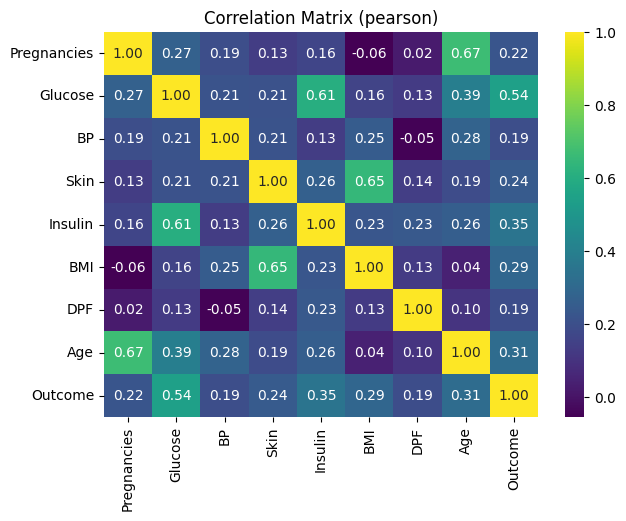

In [14]:
plot_eda.plot_correlation_matrix(data_no_missing) # pearson coefficient only for linear correlations

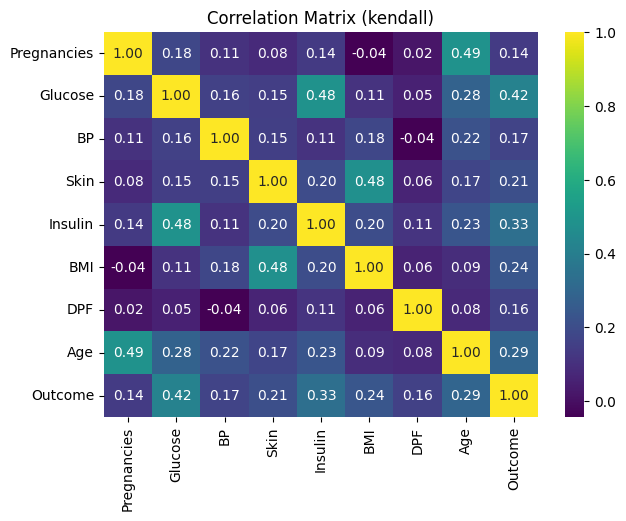

In [15]:
plot_eda.plot_correlation_matrix(data_no_missing, "kendall") # kendall correlation based on rank (not linear but montonous) coefficient only for linear correlations

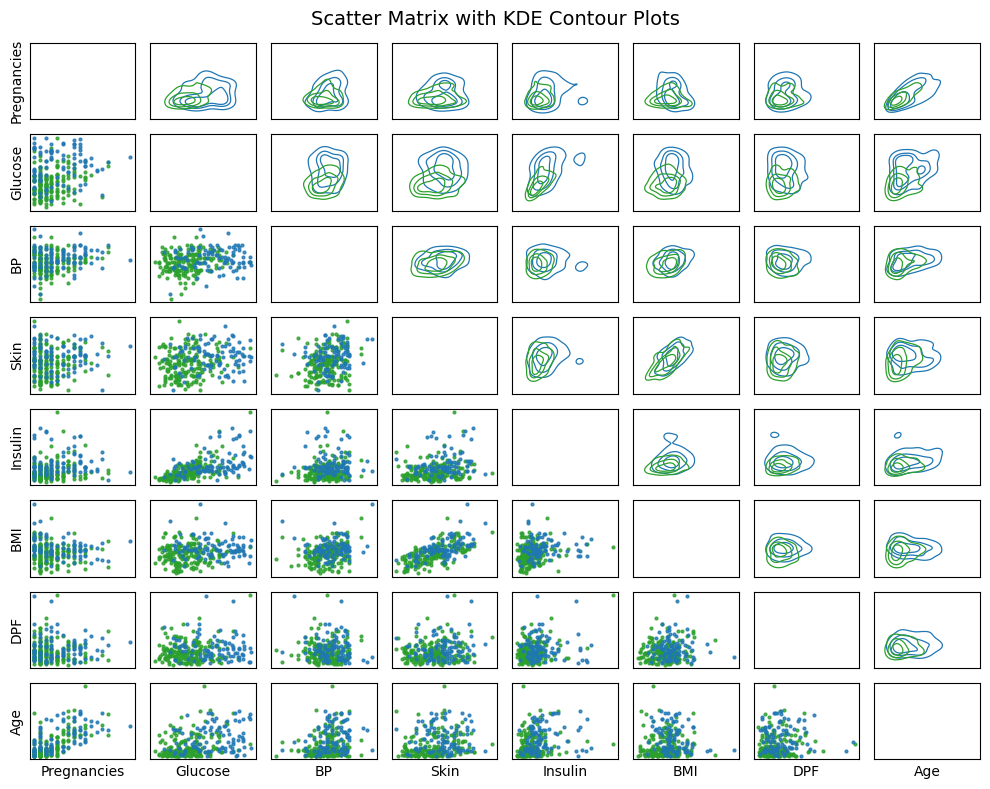

In [16]:
plot_eda.plot_scatter_matrix_with_kde(data_no_missing, features, target)

#### PCA

- PCA helps to identify correlations beyond just linear relationships by capturing the **total variance** in the data, which includes both linear and potential nonlinear interactions between variables.

- **Three groups of variables** identified:
  - **DPF**, **Skin**, **BMI**
  - **Glucose**, **Insulin**, **BP**
  - **Age**, **Pregnancies**
  
**PCA visualization**:
- **Longer arrows** indicate that a variable has a **stronger correlation** with the principal components, meaning it contributes more to the data's overall variation.
- **Shorter arrows** indicate that a variable contributes **less** to the variation, having a lower correlation with the principal components.
- When arrows are **close together**, it means the variables are **strongly correlated**.
- When arrows are **far apart**, it indicates **weaker correlation** between the variables.


In [17]:
# apply standard scaler and PCA 
X = data_no_missing.drop("Outcome", axis = 1)
X_pca, pca = data_proc.standardize_apply_pca(X, n_components=2)

# variance of pc 1
pc1_variance = pca.explained_variance_ratio_[0]
print(f"Variance of first principle component (PC1): {pc1_variance:.4f}")

# variance of pc 2
pc2_variance = pca.explained_variance_ratio_[1]
print(f"Variance of second principle component (PC2): {pc2_variance:.4f}")


Variance of first principle component (PC1): 0.3289
Variance of second principle component (PC2): 0.1932


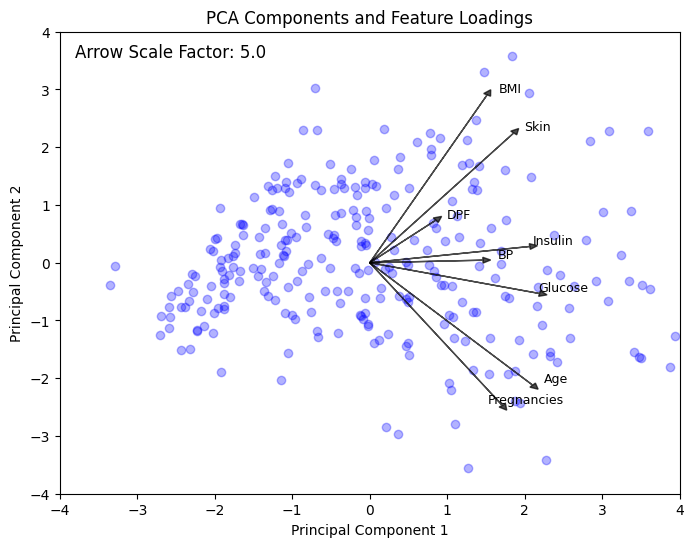

In [18]:
plot_eda.plot_pca_components(X_pca, pca, X, scale_factor=5.0, xlim=(-4, 4), ylim=(-4, 4))

## 3. Imputation Techniques

##### Comparing Four Imputer Methods

- **Mean Imputation**: Fills missing values with the mean of the feature. 

- **Median Imputation**: Fills missing values with the median of the feature (more robust to outliers).


- **KNN Imputation (based on all features)**: Imputes missing values by finding the nearest neighbors using all available features (not target variable).

- **KNN Imputation (based on PCA feature groups)**: Uses K-Nearest Neighbors (KNN) for imputing missing values, where the neighbors are selected based on feature groups identified through PCA. This method allows imputing based on relationships between correlated features.
    -  The feature groups from PCA include:
        - **DPF, Skin, BMI**
        - **Glucose, Insulin, BP**
        - **Age, Pregnancies** (features with no missing values, not important for imputation)



In [19]:
scaler = StandardScaler()  # Standard scaler for feature scaling

pipeline_mean = Pipeline([
    ('scaler', scaler),                      # Scale the features
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('inverse_scaler', pipeline_comp.InverseScaler(scaler))  # Inverse scale back to original values
])

pipeline_median = Pipeline([
    ('scaler', scaler),                      # Scale the features
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with the median
    ('inverse_scaler', pipeline_comp.InverseScaler(scaler))  # Inverse scale back to original values
])

pipeline_knn = Pipeline([
    ('scaler', scaler),                      # Scale the features
    ('imputer', KNNImputer(n_neighbors=10, weights='uniform')),  # Impute missing values with KNN
    ('inverse_scaler', pipeline_comp.InverseScaler(scaler))  # Inverse scale back to original values
])

pipeline_knn_pca = Pipeline([
    ('scaler', scaler),                      # Scale the features
    ('imputer', pipeline_comp.KNNImputationByGroup(columns=features, n_neighbors=10, weights='uniform')),  # KNN imputation by group
    ('inverse_scaler', pipeline_comp.InverseScaler(scaler))  # Inverse scale back to original values
])

pipelines_dict = {
                    'knn pca': pipeline_knn_pca,
                    'knn': pipeline_knn,
                    'mean': pipeline_mean,
                    'median': pipeline_median,
                }


#### Comparing Imputation Methods

In [20]:
# Replace zeros with NaN in the features that have missing values (otherwise imputing wont work)
data[features_no_measurements] = data[features_no_measurements].replace(0, np.nan)
# Define mas to track whether values have been imputed (True represents impute values)
missing_values_mask = data.isna()

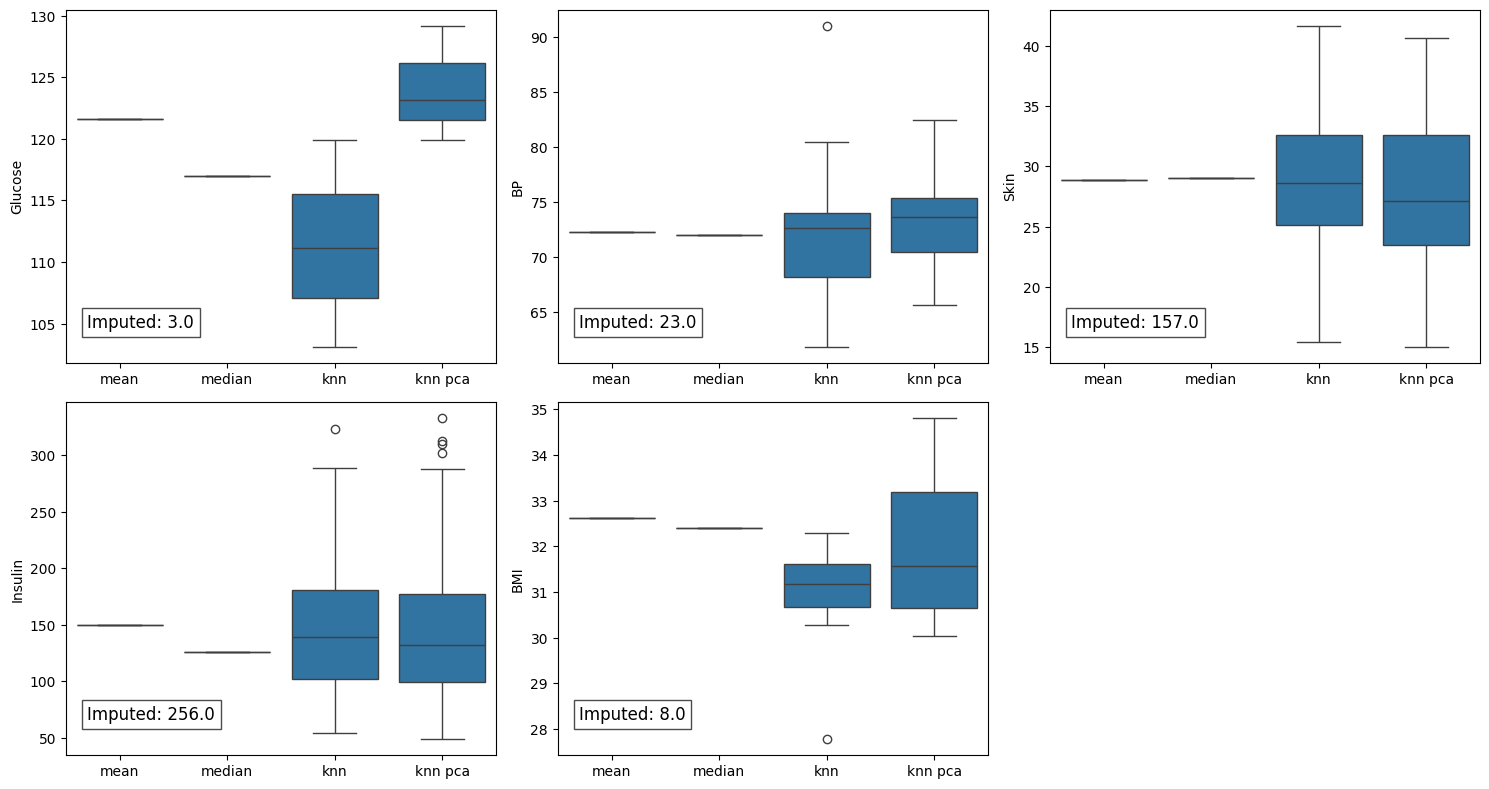

In [21]:
# Impute using different methods (returns nan for elements which were not imputed) 
data_mean_imp = data_proc.impute_and_extract_missing(data, features, target, "mean", pipelines_dict, missing_values_mask)
data_median_imp = data_proc.impute_and_extract_missing(data, features, target, "median", pipelines_dict, missing_values_mask)
data_knn_imp = data_proc.impute_and_extract_missing(data, features, target, "knn", pipelines_dict, missing_values_mask)
data_knn_pca_imp = data_proc.impute_and_extract_missing(data, features, target, "knn pca", pipelines_dict, missing_values_mask)

# Combine all imputation methods into one DataFrame
data_combined = pd.concat([data_mean_imp, data_median_imp, data_knn_imp, data_knn_pca_imp], ignore_index=True)

# Visualise the imputation methods
plot_eda.plot_comparison_imputation_methods(data_combined, features_no_measurements)


#### Evaluation of Imputing Methods

1. **Artificially insert missing values** into a dataset with no missing values, mimicking the fraction of missing values in the full training data.
2. **Apply imputation techniques** (e.g., mean, median, KNN) and test with varying neighbors (1-20).
3. **Calculate RMSE** between original and imputed values to measure accuracy.
4. **Run 10 experiments** with different missing data positions for each $n$ (1–20 neighbors), ensuring that Run 1 for $n=1$ has the same missing values as Run 1 for $n=2$, and so on until run 10.

In [22]:
data_no_missing, data_with_missing = data_proc.create_artificial_missing_data(data, random_state=42)

In [23]:
data_no_missing.head(), data_with_missing.head()

(   Pregnancies  Glucose    BP  Skin  Insulin   BMI    DPF  Age  Outcome
 0            2    106.0  64.0  35.0    119.0  30.5  1.400   34        0
 1            2    100.0  54.0  28.0    105.0  37.8  0.498   24        0
 2            3    174.0  58.0  22.0    194.0  32.9  0.593   36        1
 3            0    152.0  82.0  39.0    272.0  41.5  0.270   27        0
 4            0     74.0  52.0  10.0     36.0  27.8  0.269   22        0,
    Pregnancies  Glucose    BP  Skin  Insulin   BMI    DPF  Age  Outcome
 0            2    106.0  64.0  35.0    119.0   NaN  1.400   34        0
 1            2    100.0  54.0  28.0      NaN  37.8  0.498   24        0
 2            3    174.0  58.0  22.0      NaN  32.9  0.593   36        1
 3            0    152.0  82.0  39.0      NaN  41.5  0.270   27        0
 4            0     74.0  52.0  10.0      NaN  27.8  0.269   22        0)

In [24]:
rmse_results = data_proc.run_pipeline_for_neighbors(data, pipelines_dict, n_neighbors_range=range(1, 21))

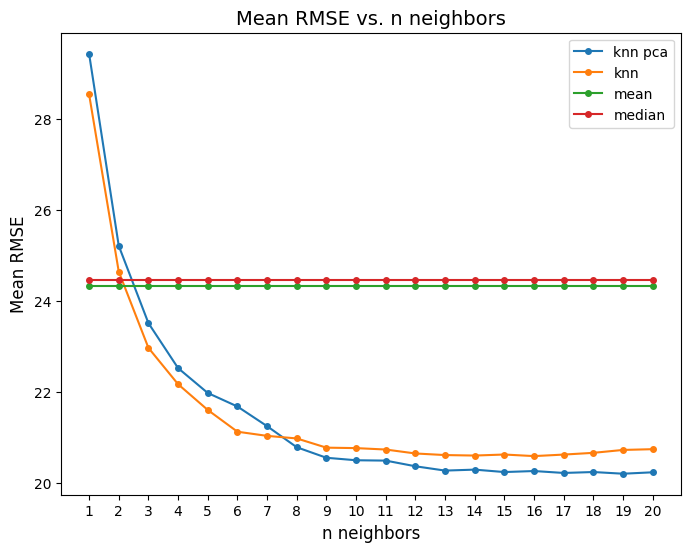

In [25]:
plot_eda.plot_rmse_vs_neighbors(rmse_results)

#### Summary:
- The **mean** imputation method generally shows lower RMSE compared to the **median**.
- **KNN imputation** performance improves as the number of neighbors increases.
- The optimal choice is **n=10 neighbors**, as this seems to provide stable results, showing an "elbow" in RMSE behavior.

## 4. K-Means Clustering for Feature Engineering

- **Feature Engineering**:**K-means clustering** to create a new feature.
- **Goal**: The new feature may enhance the model’s performance.
- **Method**: K-means groups similar observations into clusters.
- **Benefit**: Reveals hidden patterns not easily seen in simple analysis.

In [27]:

scaler = StandardScaler()
preprocess_features = pipeline_comp.PreprocessFeatures(features_no_measurements=['Glucose', 'BP', 'Skin', 'Insulin', 'BMI'])
features = ['Pregnancies', 'Glucose', 'BP', 'Skin', 'Insulin', 'BMI', 'DPF', 'Age']

pipeline_knn_pca = Pipeline([
    ('preprocess', preprocess_features),
    ('scaler', scaler),
    ('imputer', pipeline_comp.KNNImputationByGroup(columns=features, n_neighbors=10, weights='uniform')),
])

pipeline_knn = Pipeline([
    ('preprocess', preprocess_features),
    ('scaler', scaler),
    ('imputer', KNNImputer(n_neighbors=10, weights='uniform')),
])

pipeline_mean = Pipeline([
    ('preprocess', preprocess_features),
    ('scaler', scaler),
    ('imputer', SimpleImputer(strategy='mean')),
])

pipeline_median = Pipeline([
    ('preprocess', preprocess_features),
    ('scaler', scaler),
    ('imputer', SimpleImputer(strategy='median')),
])

pipelines_dict = {
    'knn pca': pipeline_knn_pca,
    'knn': pipeline_knn,
    'mean': pipeline_mean,
    'median': pipeline_median,
}


In [28]:
# create dict with data sets for the 4 different imputation techniques
data_imputed_dict = data_proc.generate_imputed_datasets(pipelines_dict, data, features, target)

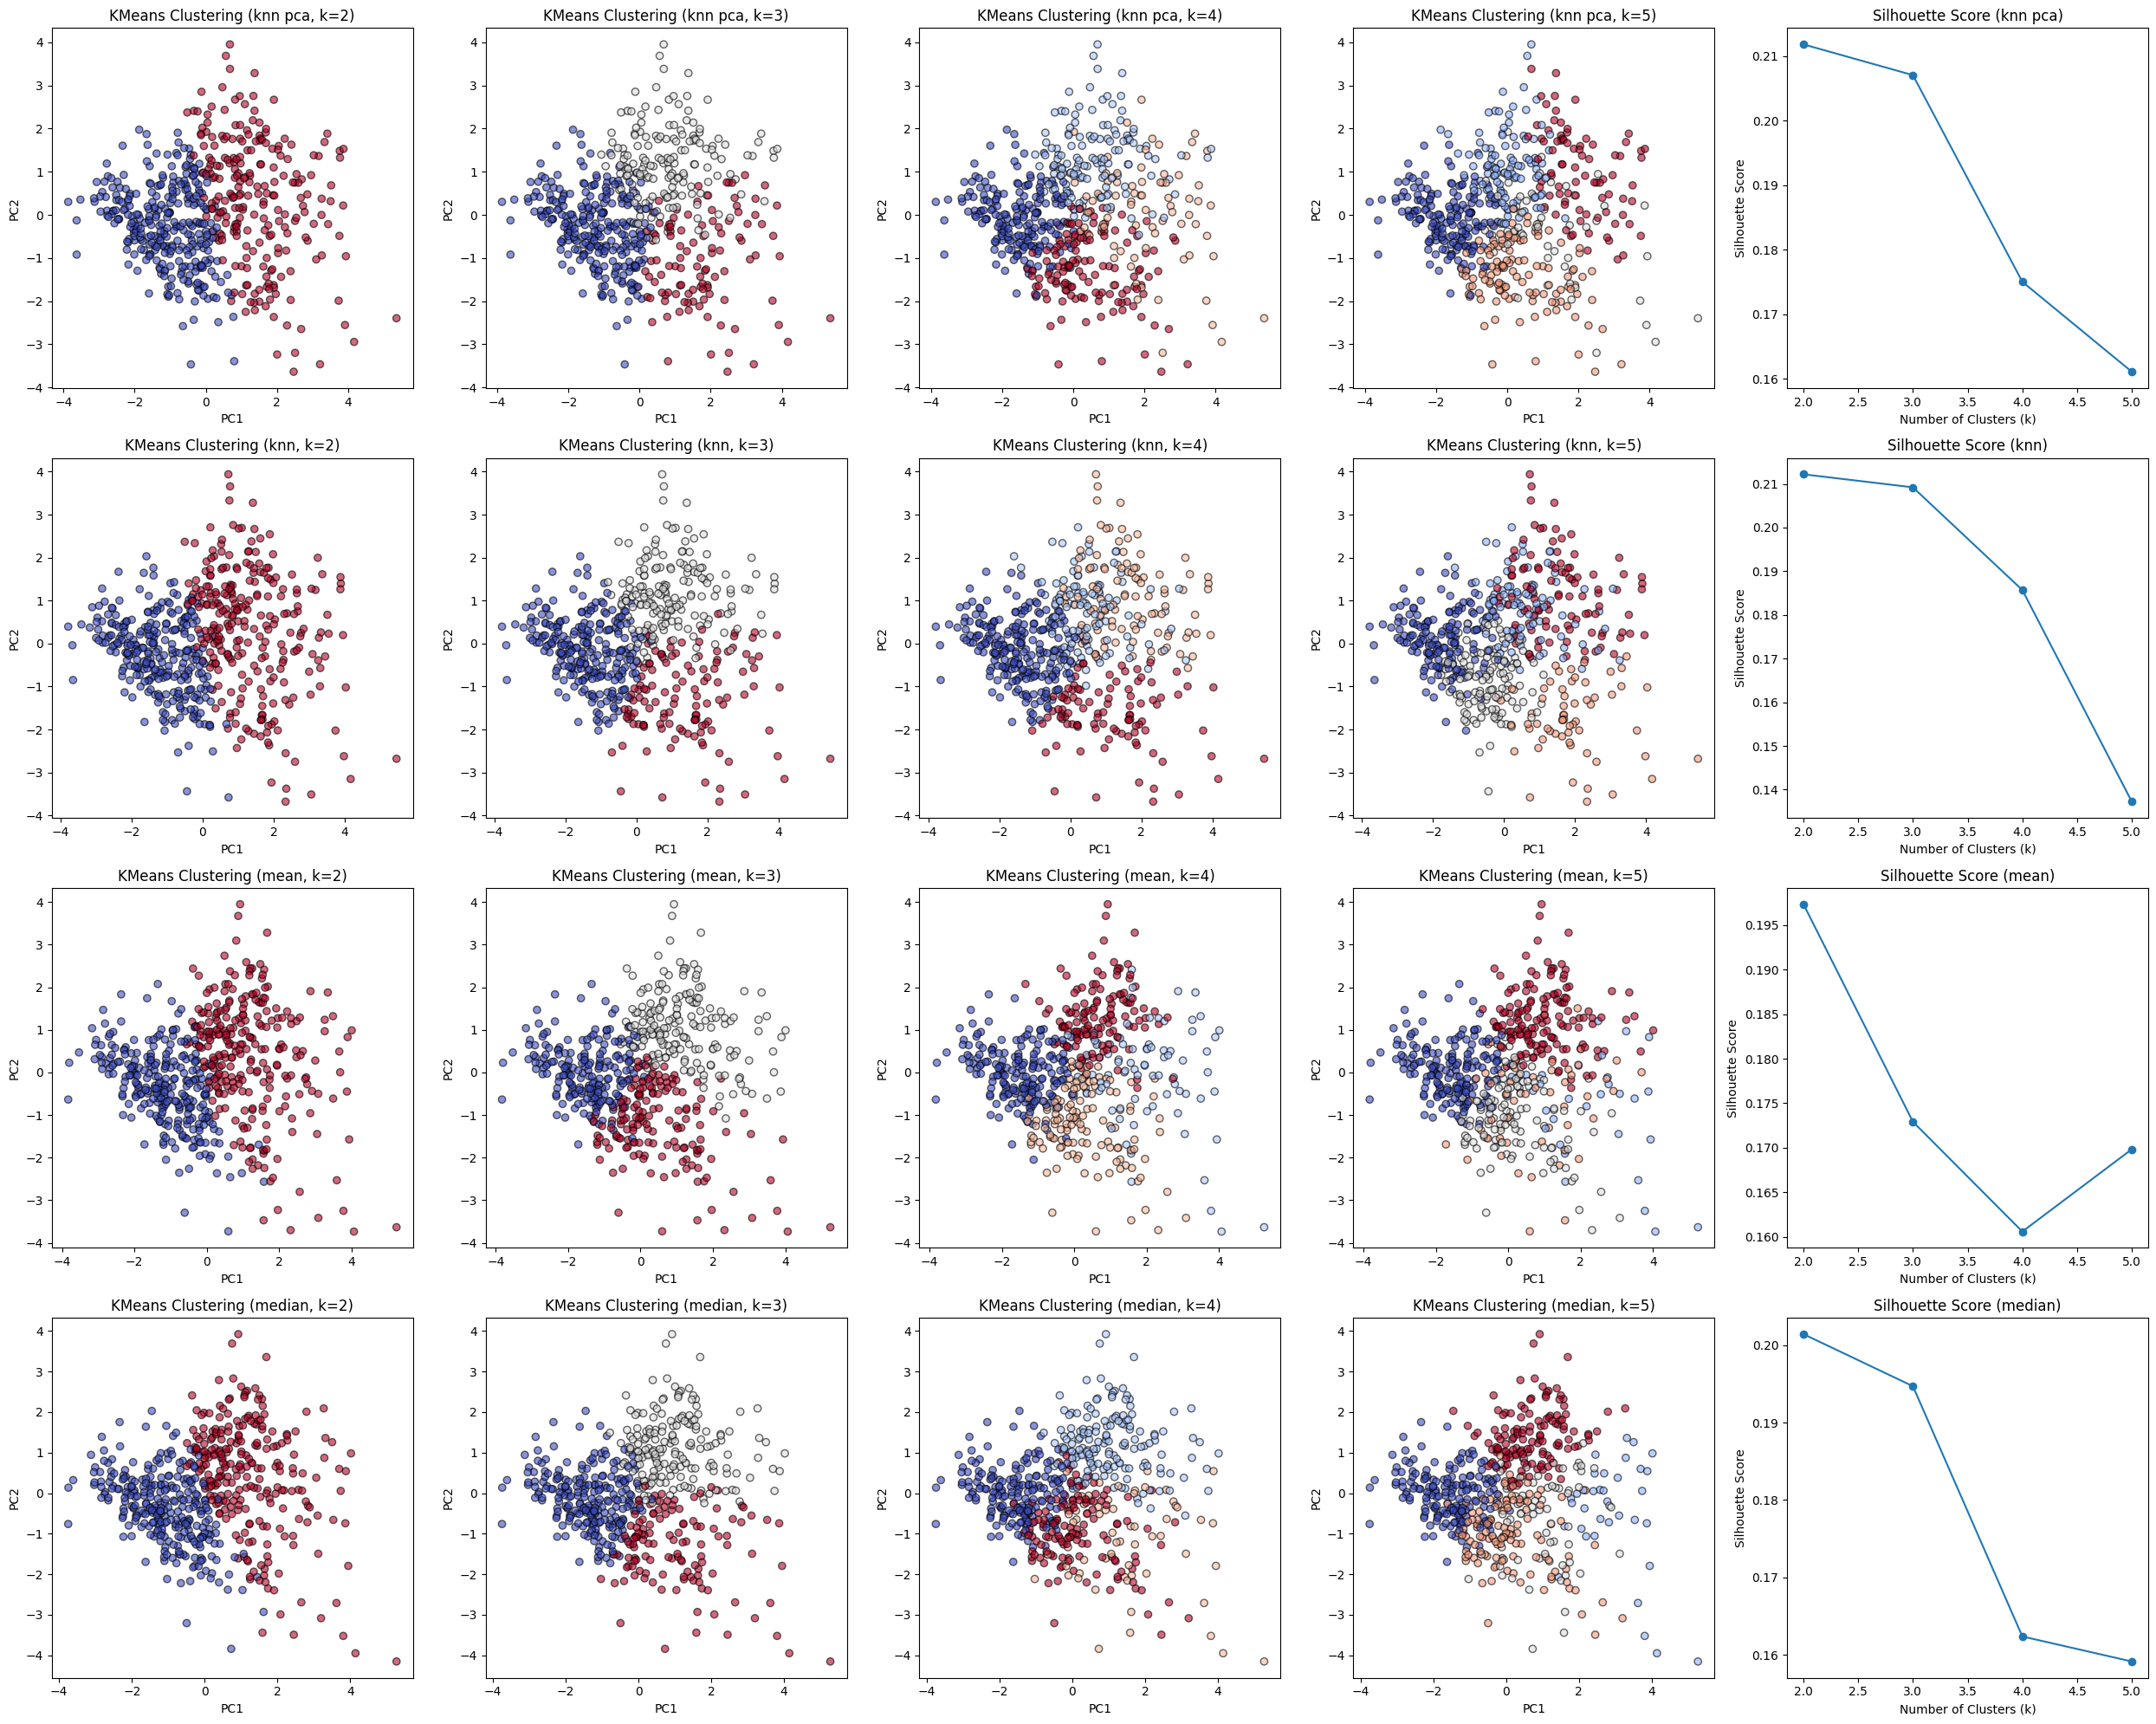

In [29]:
plot_eda.plot_kmeans_clustering_with_silhouette(data_imputed_dict, features, k_max=5)

#### Summary:
- The optimal number of clusters for improving imputation techniques is **2**.
- **3 clusters** can be helpful for all methods except **mean imputation**.

## Conclusion
Based on this analysis, I will prepare **9 pipelines**, varying in:

- **Imputation techniques**
- **Inclusion of a new feature derived from K-means clustering (n=2)**

For each pipeline:
- **Random Forest** will be used as the classifier.
- **Hyperparameter grid search** will be applied to tune the model.

The results will be discussed in the next notebook: [02_model_evaluation.ipynb](02_model_evaluation.ipynb).